# Actual Exploratory Data Analysis

In [1]:
import os
os.chdir('../../')
import pandas as pd
import matplotlib.pyplot as plt
from scripts.post_processing import get_output
from scripts.analysis_tools_cython import *
import seaborn as sns

## Functions

In [2]:
def plot_lc(data):
    for i in data.path:
        lc, lc_info = import_XRPlightcurve(i,sector=6)
        lc = lc['time','corrected flux','quality','flux error']
        results, _ = processing(lc,'.',lc_info=lc_info,method='median',make_plots=True)

In [3]:
data = get_output('output_log/s6.txt')
data_copy = data.copy()
data = data[data.transit_prob == 'maybeTransit']
data.head()

,path,id,signal,snr,time,asym_score,width1,width2,duration,depth,peak_lspower,mstat,skewness,skewness_err,m,n,chisquare,transit_prob
4,/tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_10...,147903302,-10.609967,-3.497789,1487.326335,0.999984,0.115925,0.000451,0.395836,-0.001552,0.341522,0.106,-0.015963,4698.968264,19,877,63.410278,maybeTransit
5,/tmp/tess/tesslcs_sector_6_104/2_min_cadence_t...,7421869,-4.699760,-4.523697,1469.971635,0.945789,0.173393,0.000091,0.083332,-0.000404,0.016054,0.045,10.999105,26.412505,4,44,-4.151384,maybeTransit
6,/tmp/tess/tesslcs_sector_6_104/2_min_cadence_t...,150275360,-8.005485,-4.369734,1480.927990,1.006510,0.478477,0.000277,0.562502,-0.000441,0.030095,0.124,-8.780139,10.520628,27,564,-7.402971,maybeTransit
7,/tmp/tess/tesslcs_sector_6_104/2_min_cadence_t...,219392569,-5.567599,-2.965706,1488.762204,1.050655,1.149052,0.000545,0.312495,-0.000352,0.045527,-0.031,-6.438131,4.768492,15,946,7.102634,maybeTransit
8,/tmp/tess/tesslcs_sector_6_104/2_min_cadence_t...,393803598,-7.612133,-4.279872,1488.202056,1.000387,0.184863,0.000606,0.395825,-0.001591,0.035800,0.025,0.986537,2.057052,19,921,-34.130141,maybeTransit


## Removing bad data
From early plots, we know that there is a fair amount of bad data. This includes:
- Lightcurves with mysterious large dips that occur in the space of ~5-10 cadences that do not show up in any other lightcurve pipeline (includeing direct `eleanor` lightcurves. 
- Models fitted on the data have ridiculous skewness values.
We will remove these from the dataset.

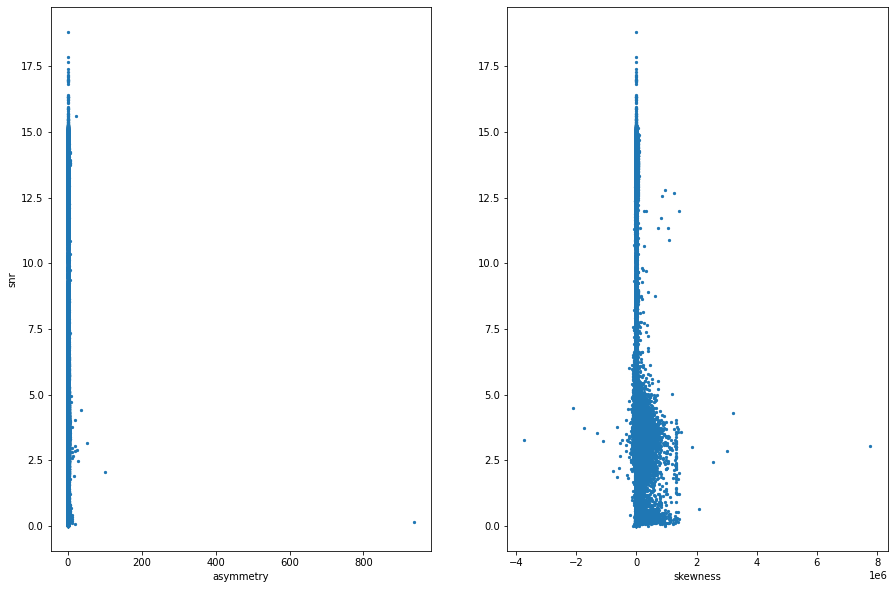

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,10))
ax[0].scatter(data.asym_score,abs(data.snr),s=5)
ax[0].set_xlabel("asymmetry")
ax[1].set_xlabel("skewness")
ax[0].set_ylabel("snr")
ax[1].scatter(data.skewness,abs(data.snr),s=5)
plt.show()

In [5]:
data = data[(data.asym_score <= 10) & (data.skewness >= -100) & (data.skewness <= 100)].reset_index(drop=True)

### Scatterplot after removing most aggressive outliers

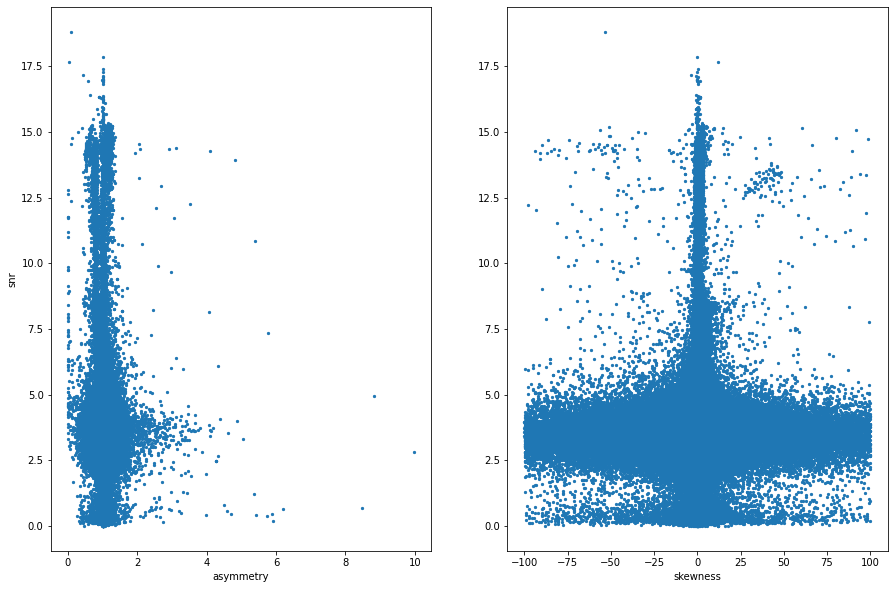

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,10))
ax[0].scatter(data.asym_score,abs(data.snr),s=5)
ax[0].set_xlabel("asymmetry")
ax[1].set_xlabel("skewness")
ax[0].set_ylabel("snr")
ax[1].scatter(data.skewness,abs(data.snr),s=5)
plt.show()

### Histograms of time and duration
- We know there are bad lightcurves in the XRP batch

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbc6519c710>]],
      dtype=object)

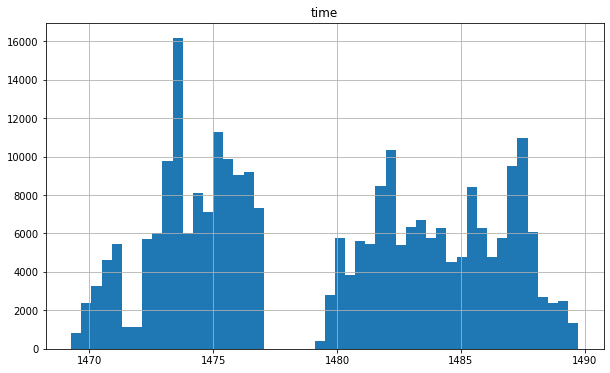

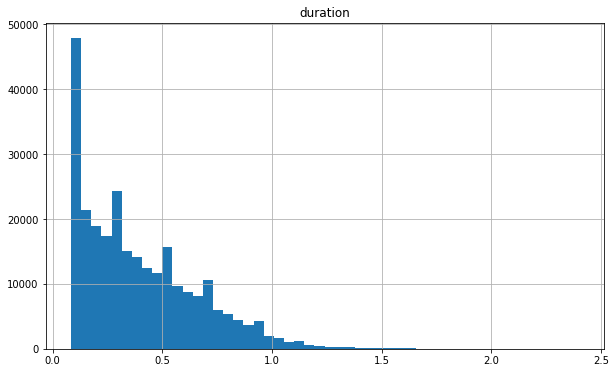

In [7]:
data.hist('time',bins=50,figsize=(10,6))
data.hist('duration',bins=50,figsize=(10,6))


### Do the spikes on these histograms happen at a specific time?

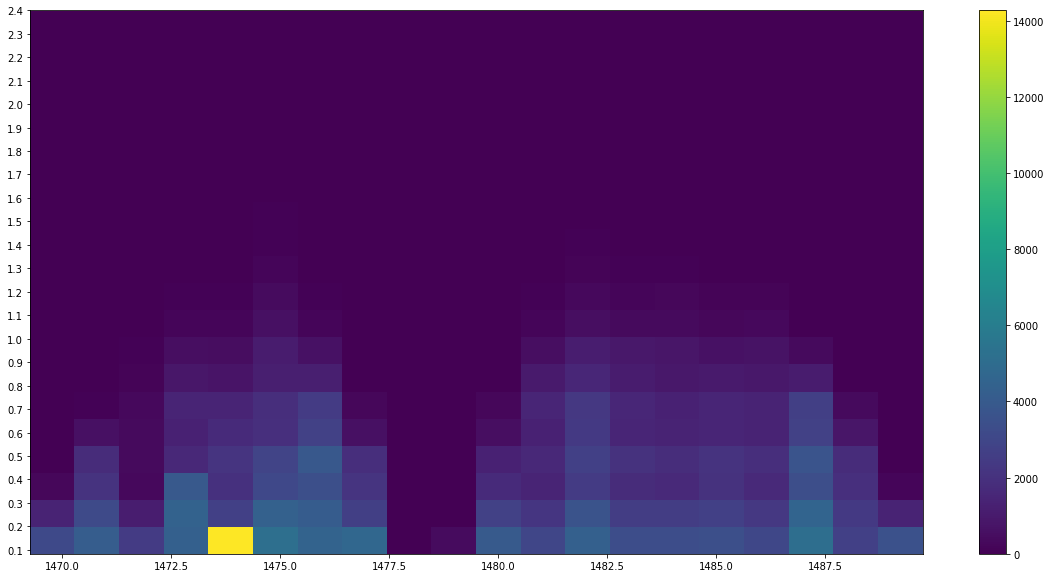

In [8]:
plt.figure(figsize=(20,10))
plt.hist2d(data['time'], data['duration'], bins=[20, 20])
plt.yticks(ticks=np.arange(0.1,2.5,0.1))
plt.colorbar()
plt.show()

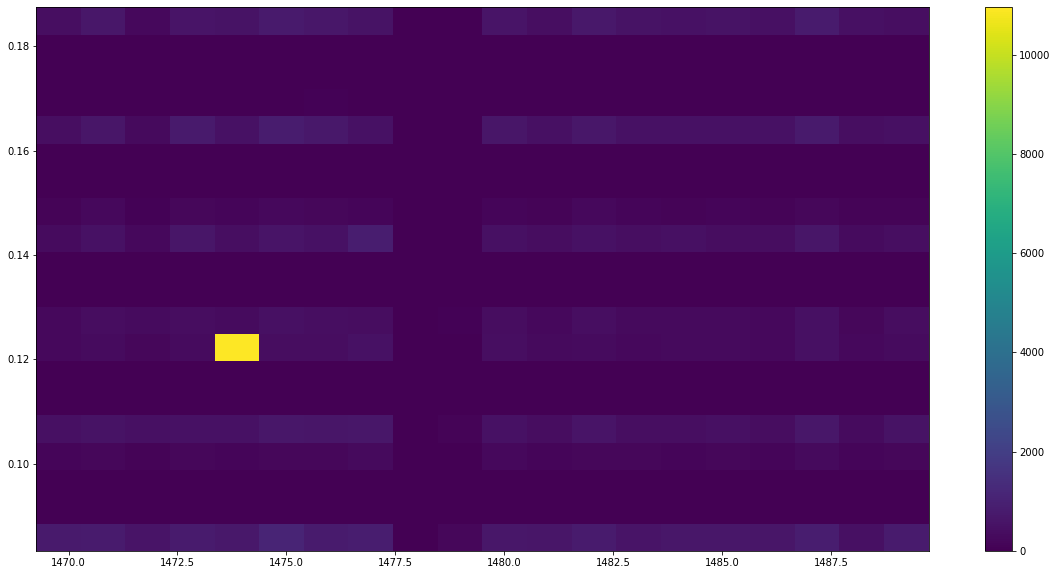

In [9]:
plt.figure(figsize=(20,10))
plt.hist2d(data['time'][data.duration <= 0.2], data['duration'][data.duration <= 0.2], bins=[20, 20])
plt.colorbar()
plt.show()

Yes, they do.

#### Let's zoom in to that time range where there is a spike at 1473, and re-plot

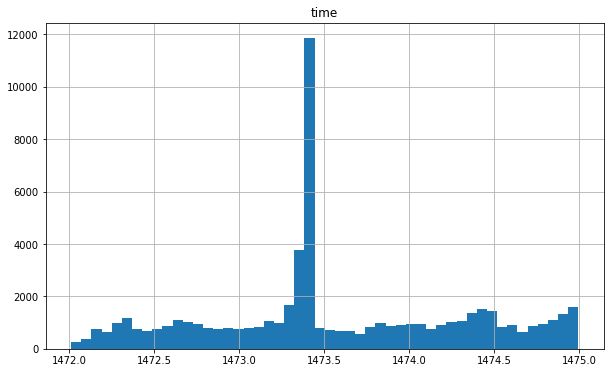

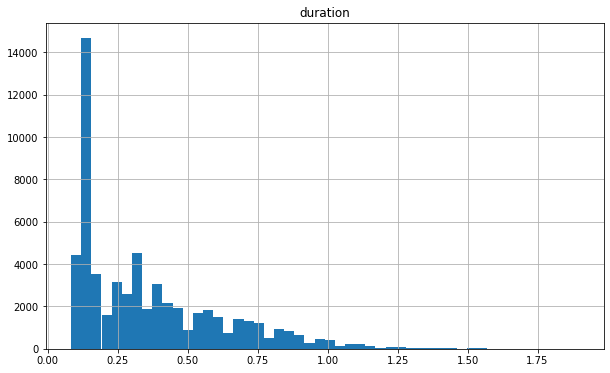

In [10]:
data.loc[(data.time >=1472) & (data.time <= 1475)].hist('time',bins=50,figsize=(10,6))
data.loc[(data.time >=1472) & (data.time <= 1475)].hist('duration',bins=50,figsize=(10,6))
plt.show()

From some analysis of the clusters in the above skewness plots, we find that the failed lightcurves have a property of `duraion ~ 0.125` and `time = 1473.433` so we drop all lightcurves in that range.

**Drop this data**

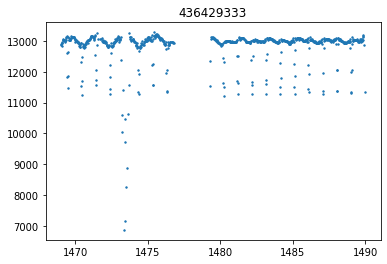

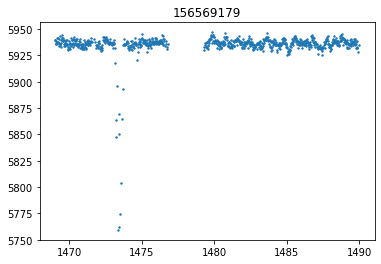

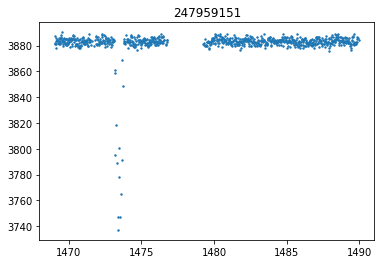

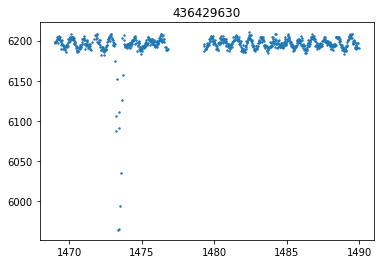

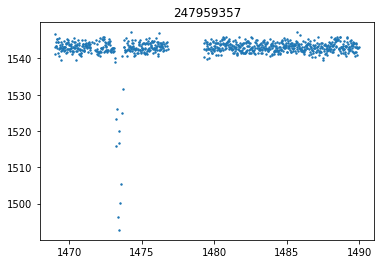

In [11]:
to_cut = data[(data['duration'] <= 0.125) & (data['time'] >= 1473.433) & (data['time'] <= 1473.434)]
for i in to_cut.path.head():
    lc, lc_info = import_XRPlightcurve(i,sector=6)
    plt.scatter(lc['time'],lc['corrected flux'],s=2)
    #plt.scatter(data['TIME'],data['PDCSAP_FLUX'],s=2)
    plt.title(lc_info[0])
    plt.show()

In [12]:
data.drop(data[(data['duration'] <= 0.125) & (data['time'] >= 1473.433) & (data['time'] <= 1473.434)].index,inplace=True)
data.head()

,path,id,signal,snr,time,asym_score,width1,width2,duration,depth,peak_lspower,mstat,skewness,skewness_err,m,n,chisquare,transit_prob
0,/tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_10...,147903302,-10.609967,-3.497789,1487.326335,0.999984,0.115925,0.000451,0.395836,-0.001552,0.341522,0.106,-0.015963,4698.968264,19,877,63.410278,maybeTransit
1,/tmp/tess/tesslcs_sector_6_104/2_min_cadence_t...,7421869,-4.699760,-4.523697,1469.971635,0.945789,0.173393,0.000091,0.083332,-0.000404,0.016054,0.045,10.999105,26.412505,4,44,-4.151384,maybeTransit
2,/tmp/tess/tesslcs_sector_6_104/2_min_cadence_t...,150275360,-8.005485,-4.369734,1480.927990,1.006510,0.478477,0.000277,0.562502,-0.000441,0.030095,0.124,-8.780139,10.520628,27,564,-7.402971,maybeTransit
3,/tmp/tess/tesslcs_sector_6_104/2_min_cadence_t...,219392569,-5.567599,-2.965706,1488.762204,1.050655,1.149052,0.000545,0.312495,-0.000352,0.045527,-0.031,-6.438131,4.768492,15,946,7.102634,maybeTransit
4,/tmp/tess/tesslcs_sector_6_104/2_min_cadence_t...,393803598,-7.612133,-4.279872,1488.202056,1.000387,0.184863,0.000606,0.395825,-0.001591,0.035800,0.025,0.986537,2.057052,19,921,-34.130141,maybeTransit


### Scatterplot after cleaning this

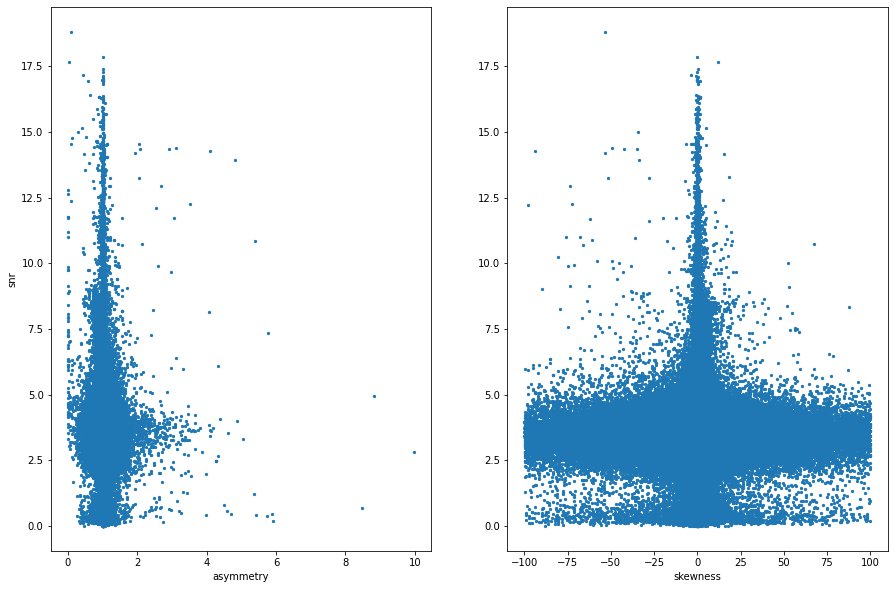

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,10))
ax[0].scatter(data.asym_score,abs(data.snr),s=5)
ax[0].set_xlabel("asymmetry")
ax[1].set_xlabel("skewness")
ax[0].set_ylabel("snr")
ax[1].scatter(data.skewness,abs(data.snr),s=5)
plt.show()

### Dropping data with high asymmetry scores

In [14]:
data.drop(data[(data['asym_score'] >= 3)].index,inplace=True)

### Scatterplot after removing high asymmetry scores

No handles with labels found to put in legend.


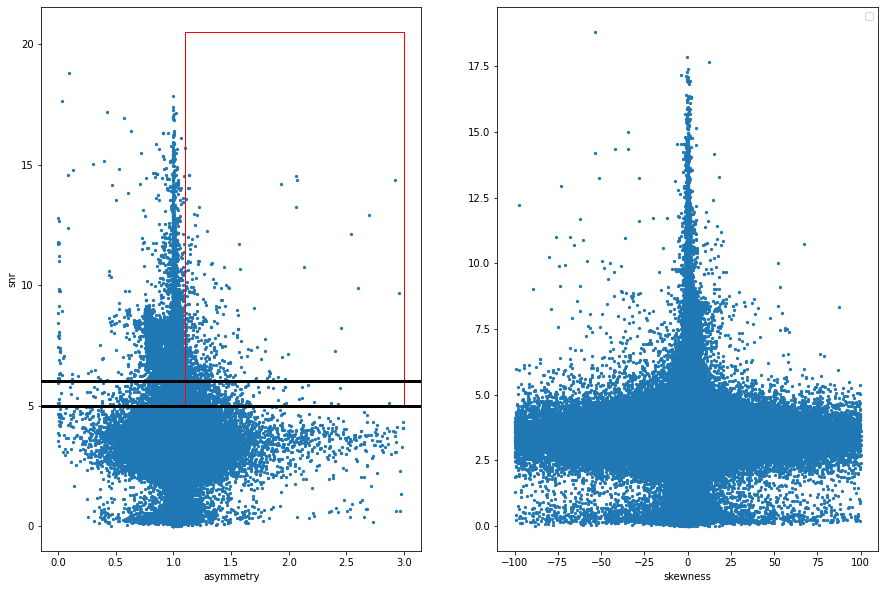

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,10))
ax[0].scatter(data.asym_score,abs(data.snr),s=5)
ax[0].set_xlabel("asymmetry")
ax[1].set_xlabel("skewness")
ax[0].set_ylabel("snr")
ax[1].scatter(data.skewness,abs(data.snr),s=5)
rect = patches.Rectangle((1.1, 5), 1.9, 15.5, linewidth=1, edgecolor='r', facecolor='none',label='Kepler box')
ax[0].add_patch(rect)
ax[0].axhline(y=5,color='black',linewidth=3)
ax[0].axhline(y=6,color='black',linewidth=3)

plt.legend()
plt.show()

---

- I would say the data is now clean from any extreme outliers. More subtle outliers still remain.

## Correlations

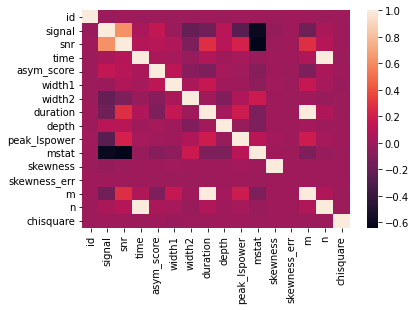

In [16]:
corr = data.corr()
sns.heatmap(corr)

In [17]:
data.snr = abs(data.snr)

### Accept only data with `snr >= 5`

In [18]:
data_new = data[data.snr >= 5].reset_index(drop=True)

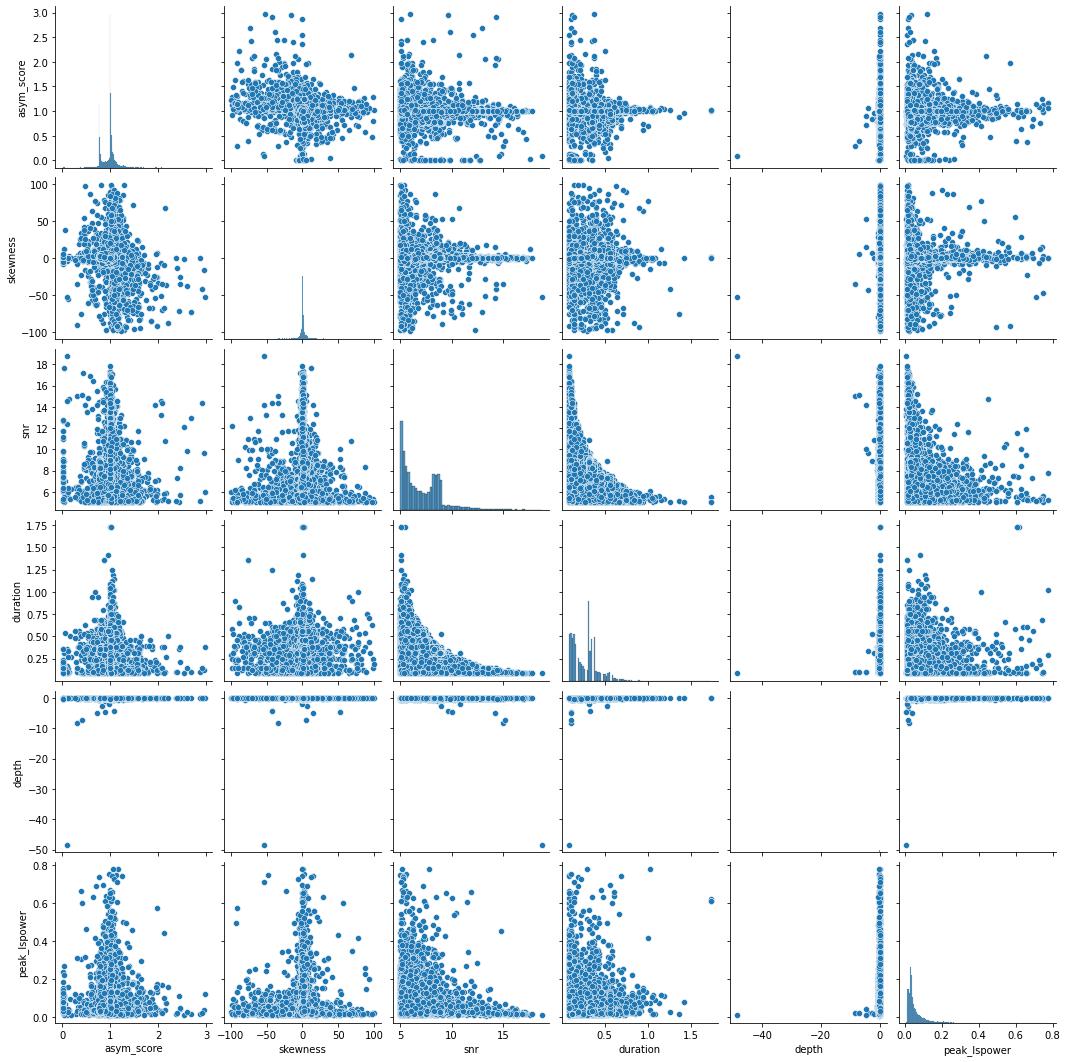

In [27]:
sns.pairplot(data_new,vars=['asym_score','skewness','snr','duration','depth','peak_lspower'])

---

In [39]:
data_new.drop(data_new[(data_new['depth'] <= -1.5)].index,inplace=True)

In [40]:
data_new

,path,id,signal,snr,time,asym_score,width1,width2,duration,depth,peak_lspower,mstat,skewness,skewness_err,m,n,chisquare,transit_prob
0,/tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_11...,20144513,-10.649570,5.118300,1470.180511,0.998714,0.041630,0.027668,0.124999,-0.262022,0.126395,1.234,-0.061055,24.015310,6,54,-181.206271,maybeTransit
1,/tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_11...,140580920,-18.106005,7.645951,1472.510240,0.999933,0.057552,0.010449,0.166665,-0.072238,0.107418,0.784,-0.157154,11.740186,8,160,-55.026720,maybeTransit
2,/tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_11...,118876585,-15.582583,9.890002,1476.619892,1.016490,0.047544,0.000530,0.104167,-0.006231,0.030561,0.301,1.656264,1.186886,5,365,-11.919521,maybeTransit
3,/tmp/tess/tesslcs_sector_6_104/2_min_cadence_t...,7422496,-15.488788,9.221545,1470.367299,1.047304,0.120517,0.000152,0.229163,-0.000846,0.025109,0.153,3.309608,1.856546,11,63,-3.460894,maybeTransit
4,/tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_10...,176759300,-10.431067,5.087807,1476.328635,1.008141,0.257855,0.000307,0.499993,-0.000806,0.047696,0.015,3.446493,2.674683,24,351,-21.973382,maybeTransit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14106,/tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_12...,80662618,-20.255766,8.208781,1473.329084,0.757951,0.272066,0.006861,0.333328,-0.015567,0.049373,0.466,2.318568,0.795780,16,207,-16.612054,maybeTransit
14107,/tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_9_...,284199911,-22.219856,8.841722,1473.349858,0.776778,0.156989,0.002021,0.312493,-0.005130,0.028719,0.492,-0.003960,22145.566780,15,208,-5.834181,maybeTransit
14108,/tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_9_...,284200082,-21.856642,8.305465,1473.329022,0.781082,0.246615,0.001572,0.354159,-0.003856,0.034664,0.500,2.148787,0.914608,17,207,-4.337133,maybeTransit
14109,/tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_9_...,284283287,-19.584366,8.279394,1473.329006,0.780748,0.288105,0.013278,0.354160,-0.029393,0.165298,0.400,2.630597,0.828387,17,207,-53.263189,maybeTransit


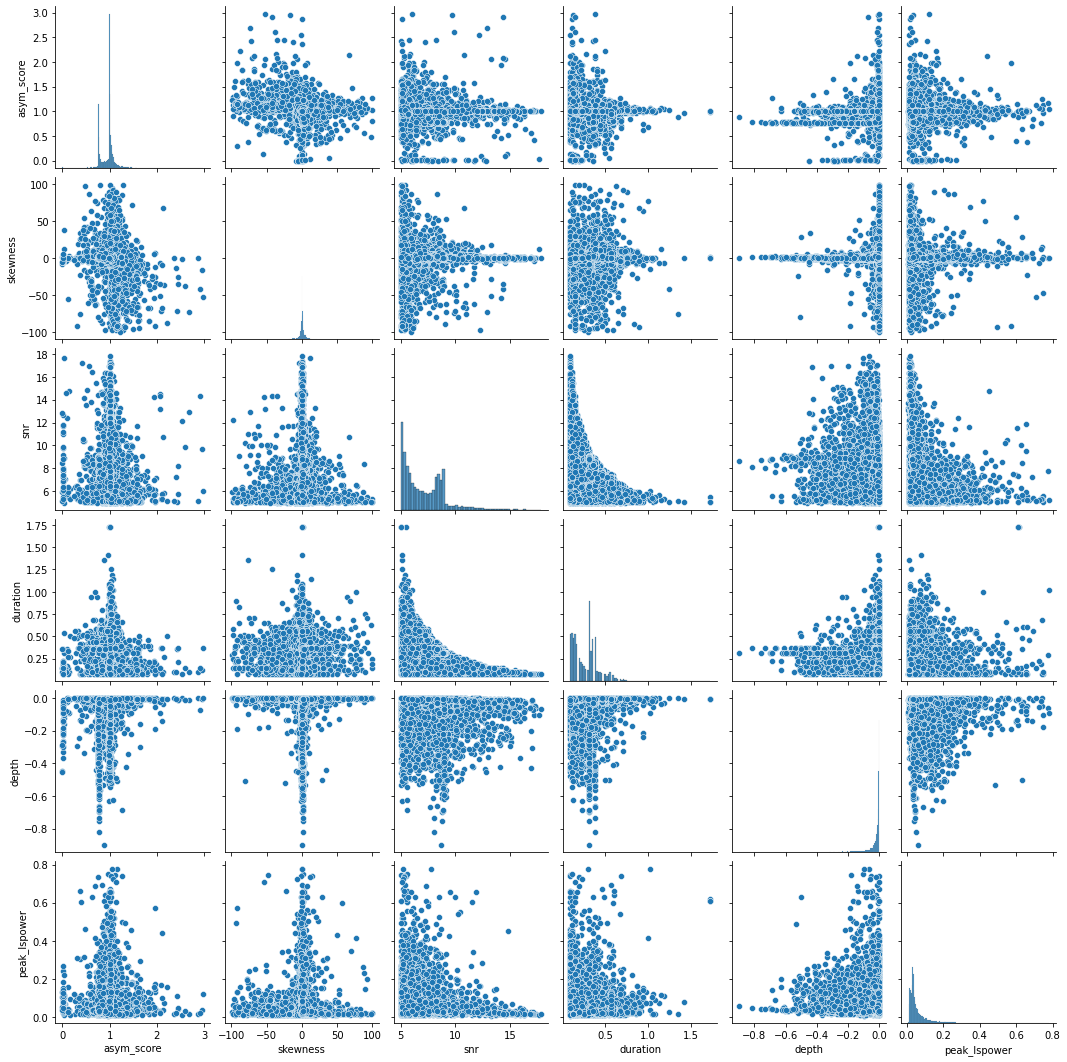

In [41]:
sns.pairplot(data_new,vars=['asym_score','skewness','snr','duration','depth','peak_lspower'])

#### Some variable comparisons

(array([[1.0653e+04, 4.1100e+02, 2.1600e+02, 1.2800e+02, 6.8000e+01,
         2.9000e+01, 1.3000e+01, 4.0000e+00, 2.0000e+00, 2.0000e+00],
        [1.3190e+03, 2.1800e+02, 9.8000e+01, 5.4000e+01, 3.7000e+01,
         1.6000e+01, 5.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.6200e+02, 8.2000e+01, 2.5000e+01, 1.7000e+01, 1.4000e+01,
         7.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.2100e+02, 2.8000e+01, 9.0000e+00, 7.0000e+00, 3.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.4000e+01, 6.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.1000e+01, 1.0000e+01, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+01, 5.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+01, 4.0000

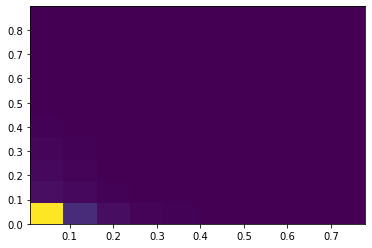

In [67]:
plt.hist2d(data_new.peak_lspower, abs(data_new.depth))

---
### Deleting `.npz` files that do not exist in the above pairplot

In [44]:
data_new.head()

,path,id,signal,snr,time,asym_score,width1,width2,duration,depth,peak_lspower,mstat,skewness,skewness_err,m,n,chisquare,transit_prob
0,/tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_11...,20144513,-10.649570,5.118300,1470.180511,0.998714,0.041630,0.027668,0.124999,-0.262022,0.126395,1.234,-0.061055,24.015310,6,54,-181.206271,maybeTransit
1,/tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_11...,140580920,-18.106005,7.645951,1472.510240,0.999933,0.057552,0.010449,0.166665,-0.072238,0.107418,0.784,-0.157154,11.740186,8,160,-55.026720,maybeTransit
2,/tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_11...,118876585,-15.582583,9.890002,1476.619892,1.016490,0.047544,0.000530,0.104167,-0.006231,0.030561,0.301,1.656264,1.186886,5,365,-11.919521,maybeTransit
3,/tmp/tess/tesslcs_sector_6_104/2_min_cadence_t...,7422496,-15.488788,9.221545,1470.367299,1.047304,0.120517,0.000152,0.229163,-0.000846,0.025109,0.153,3.309608,1.856546,11,63,-3.460894,maybeTransit
4,/tmp/tess/tesslcs_sector_6_104/tesslcs_tmag_10...,176759300,-10.431067,5.087807,1476.328635,1.008141,0.257855,0.000307,0.499993,-0.000806,0.047696,0.015,3.446493,2.674683,24,351,-21.973382,maybeTransit


In [56]:
data.id[~data.id.isin(data_new.id) == True]


0         147903302
1           7421869
2         150275360
3         219392569
4         393803598
            ...    
267721     42564913
267722     42565640
267723      4256612
267724     42567448
267725     42568129
Name: id, Length: 242853, dtype: int64

In [57]:
def delete_files_with_numbers(numbers, directory):
    for filename in os.listdir(directory):
        for number in numbers:
            if str(number) in filename:
                file_path = os.path.join(directory, filename)
                os.remove(file_path)
                print(f"Deleted file: {file_path}")

In [58]:
delete_files_with_numbers(data.id[~data.id.isin(data_new.id) == True].values,'som_cutouts_copy/')

Deleted file: som_cutouts_copy/263343910.npz
Deleted file: som_cutouts_copy/287435404.npz
Deleted file: som_cutouts_copy/235155837.npz
Deleted file: som_cutouts_copy/51927166.npz
Deleted file: som_cutouts_copy/71795259.npz
Deleted file: som_cutouts_copy/333341661.npz
Deleted file: som_cutouts_copy/123674479.npz
Deleted file: som_cutouts_copy/765028752.npz
Deleted file: som_cutouts_copy/47544996.npz
Deleted file: som_cutouts_copy/391890833.npz


KeyboardInterrupt: 

In [80]:
def delete_files_with_numbers(numbers, directory):
    ### quicker as it uses a `set` data structure to store the numbers quicker -> in my case, it might not actually be quicker. We have no duplicate ID
    number_set = set(str(number) for number in numbers)  # Convert numbers to a set for faster membership check
    for filename in os.listdir(directory):
        if any(number in filename for number in number_set):
            file_path = os.path.join(directory, filename)
            os.remove(file_path)
    print(f"Deleted files")

In [81]:
delete_files_with_numbers(data.id[~data.id.isin(data_new.id) == True].values,'som_cutouts_copy/')

KeyboardInterrupt: 

In [83]:
def load_files_with_numbers(numbers, directory='som_cutouts_copy/'):
    number_set = set(str(number) for number in numbers)
    npz_files = glob.glob(os.path.join(directory, '*.npz'))
    matching_files = [filename for filename in npz_files if any(number in filename for number in number_set)]
    loaded_data = []
    for filename in matching_files:
        data = np.load(filename)
        loaded_data.append(data)
        print(f"Loaded file: {filename}")
    return loaded_data

In [91]:
load = data.path[~data.path.isin(data_new.path) == True].values

### Producing SOM cutouts of only specific candidates

In [ ]:
for i in load:
    lc, lc_info = import_XRPlightcurve(i,sector=6)
    lc = lc['time','corrected flux','quality','flux error']
    results, _ = processing(lc,lc_info=lc_info,method='median',som_cutouts=True)
    #plt.scatter(data['TIME'],data['PDCSAP_FLUX'],s=2)


In [114]:
data.path[~data.path.isin(data_new.path) == True].to_csv('paths.csv')